In [270]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import utils.paths as path
import utils.data_cleaning
import missingno

In [271]:
data_dir = path.make_dir_function('data')

In [272]:
df_hurtos = pd.read_csv(data_dir('pre_process','hurtos.csv'),sep=',')
#nuevo df sin columnas innecesarias
df = df_hurtos.copy()
df.drop(['DIRECTORIO', 'NRO_ENCUESTA', 'SECUENCIA_ENCUESTA', 'SECUENCIA_P',
       'ORDEN', 'FEX_C','municipio'],axis=1,inplace=True)

In [273]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16188 entries, 0 to 16187
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   mes_ultimo_unico_robo      16188 non-null  object
 1   metodo                     16188 non-null  object
 2   hora                       16045 non-null  object
 3   lugar                      16188 non-null  object
 4   celular                    16188 non-null  object
 5   efectivo_tarjetas          16188 non-null  object
 6   articulos_de_uso_personal  16188 non-null  object
 7   dispositivos               16188 non-null  object
 8   otra_pertenencia           16188 non-null  object
 9   arma_fuego                 13826 non-null  object
 10  arma_blanca                13826 non-null  object
 11  otros_objetos              13826 non-null  object
 12  fuerza_fisica              13826 non-null  object
 13  drogas_sustancias          13826 non-null  object
 14  hizo_l

# Valores faltantes

In [274]:
#numero de valores faltantes
df.ms_tools.number_missing()

78225

### ¿Qué valores faltantes tenemos por cada columna?

In [275]:
df.isnull().sum()

mes_ultimo_unico_robo            0
metodo                           0
hora                           143
lugar                            0
celular                          0
efectivo_tarjetas                0
articulos_de_uso_personal        0
dispositivos                     0
otra_pertenencia                 0
arma_fuego                    2362
arma_blanca                   2362
otros_objetos                 2362
fuerza_fisica                 2362
drogas_sustancias             2362
hizo_llamada                     0
denuncia                         0
lugar_denuncia               11049
autoridad                    11752
razon_denuncia               11049
buena_atencion               12588
razon_de_satisfaccion        14695
razon_no_denuncia             5139
recuperacion_objeto              0
year                             0
dtype: int64

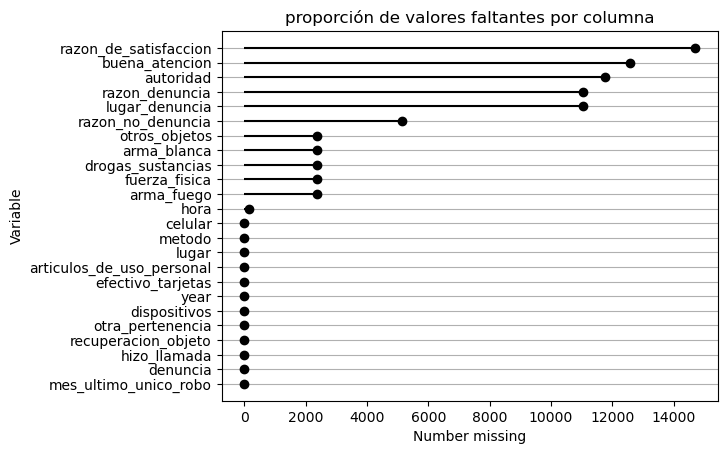

In [276]:
df.ms_tools.vis_variable_plot()
plt.title('proporción de valores faltantes por columna')
plt.show()

# ¿Qué razones pueden haber para que hayan valores faltantes?

<AxesSubplot: >

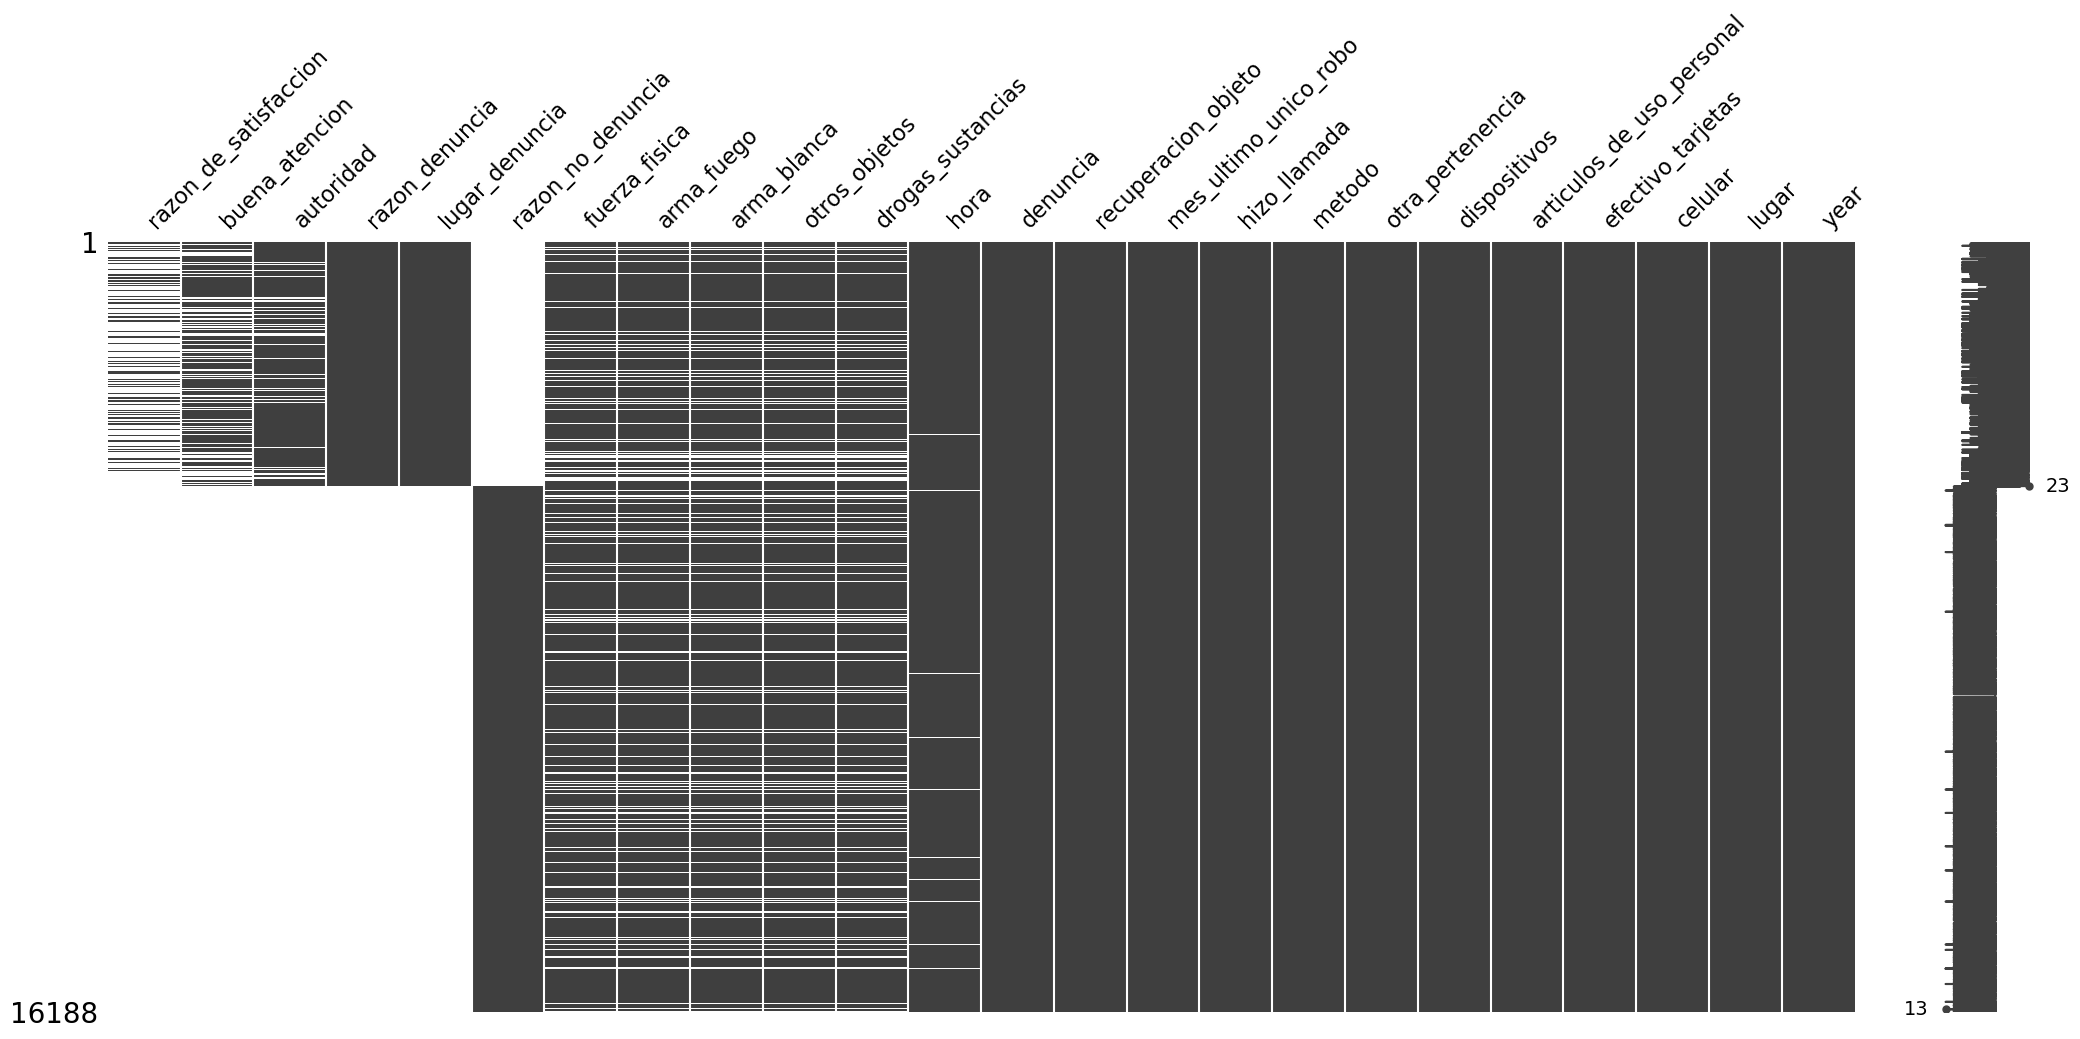

In [277]:
(
    df
    .ms_tools.sort_variables_by_missingness()
    .sort_values(by='razon_denuncia')
    .pipe(missingno.matrix)
)

## Valores faltantes en personas que no denunciaron

### Nota:
Al hacer la anterior clasificacion me di cuenta que la falta de tantos valores nulos
dependía de si la persona hizo o no la denuncia.
por consiguiente decido separar a las personas en dos datasets diferentes
en donde se encuentran los que denunciaron y los que no.

In [278]:
df_si_denuncia = df[df['denuncia']=='si']
df_no_denuncia = df[df['denuncia']=='no']

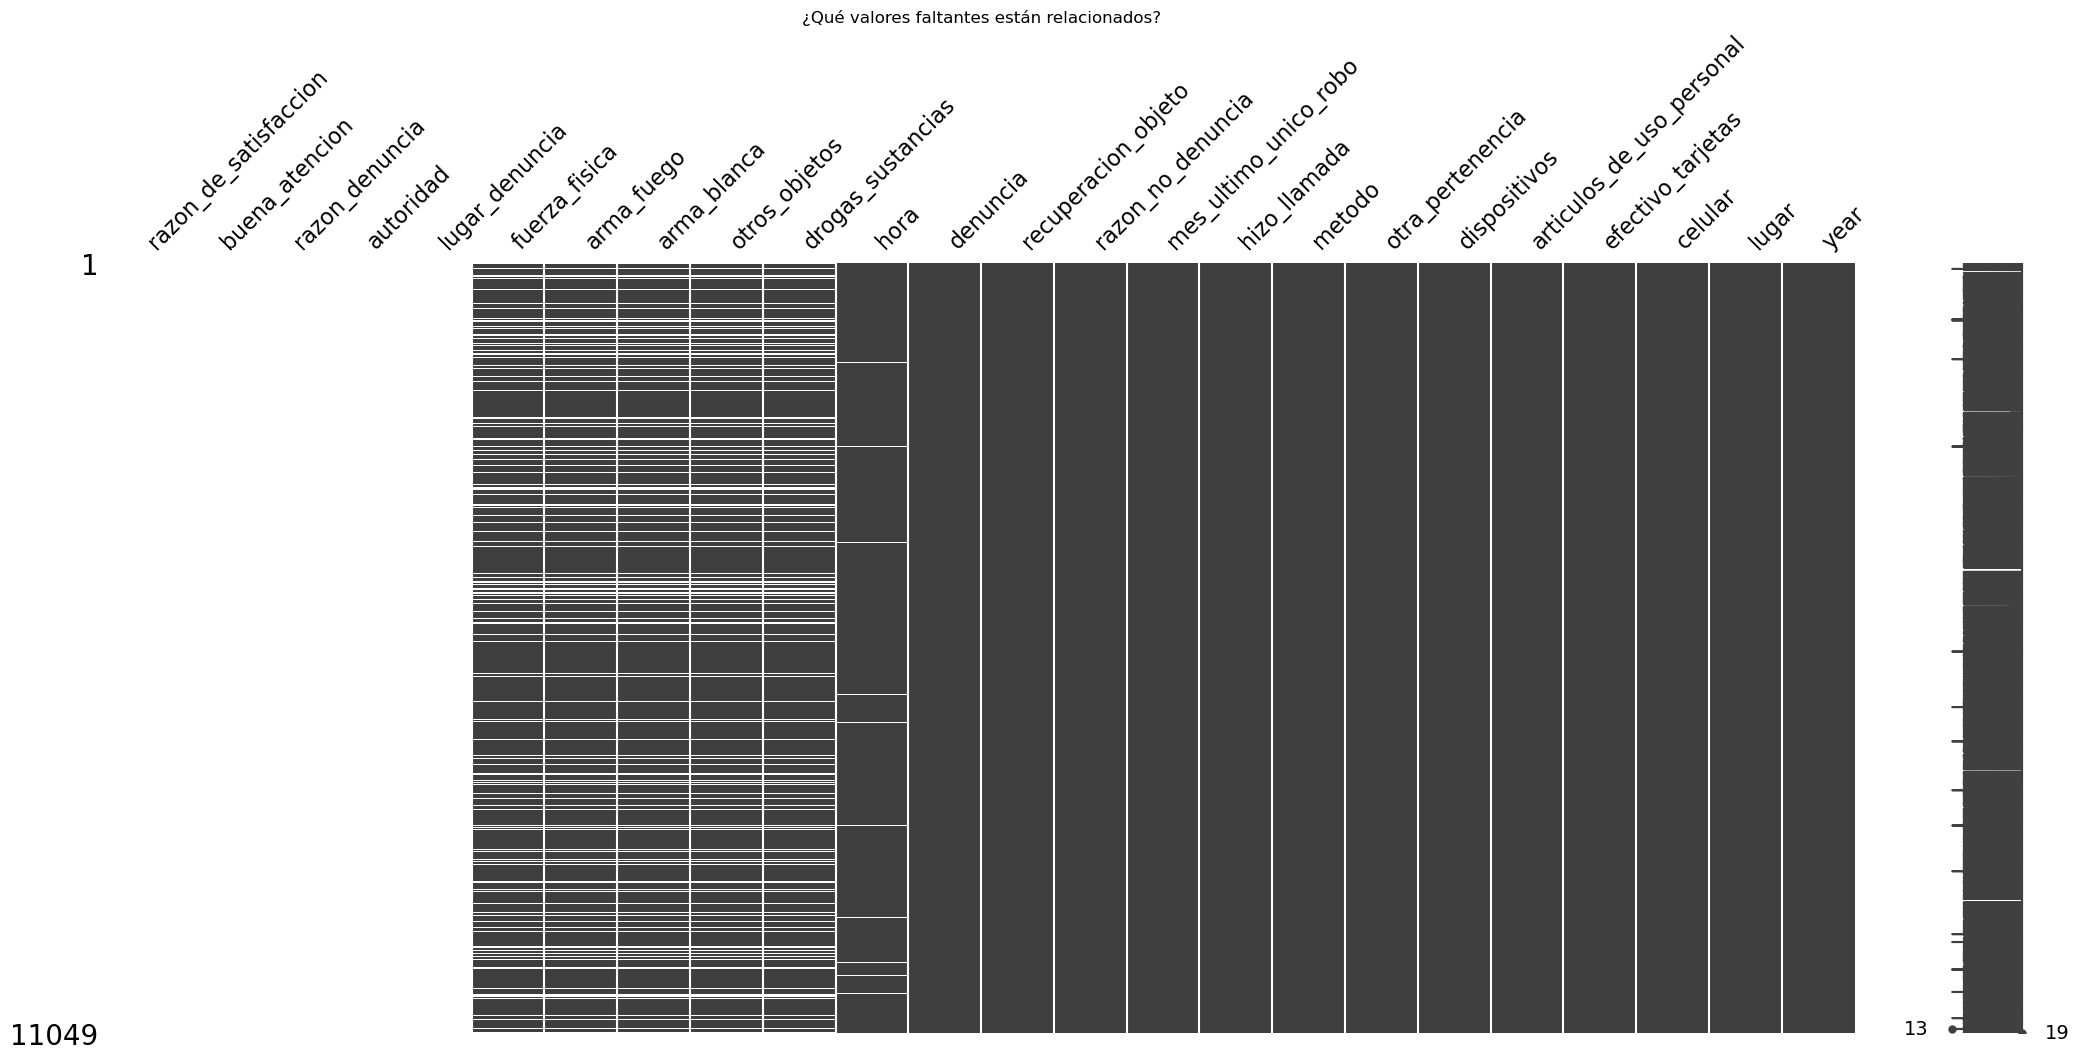

In [279]:
(
    df_no_denuncia
    .ms_tools.sort_variables_by_missingness()
    .sort_values(by='razon_denuncia')
    .pipe(missingno.matrix)
)
plt.title('¿Qué valores faltantes están relacionados?')
plt.show()

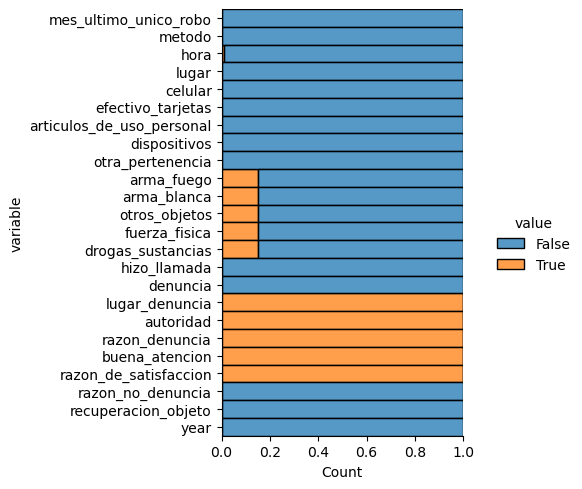

In [280]:
df_no_denuncia.ms_tools.vis_proportion()
plt.show()

### inputación de valores en personas que no denunciaron
Debido al conocimiento del contexto, voy a rellenar los valores faltantes
de las personas que no denunciaron por "no denuncia" ya que la falta de estos valores
se deben a esa razón.

In [281]:
values_to_fill = {
    'lugar_denuncia':'no_denuncia',
    'autoridad':'no_denuncia',
    'razon_denuncia':'no_denuncia',
    'buena_atencion':'no_denuncia',
    'razon_de_satisfaccion':'no_denuncia'
    }

In [282]:
df_no_denuncia = df_no_denuncia.fillna(value=values_to_fill)

## valores nulos para las personas que si denunciaron

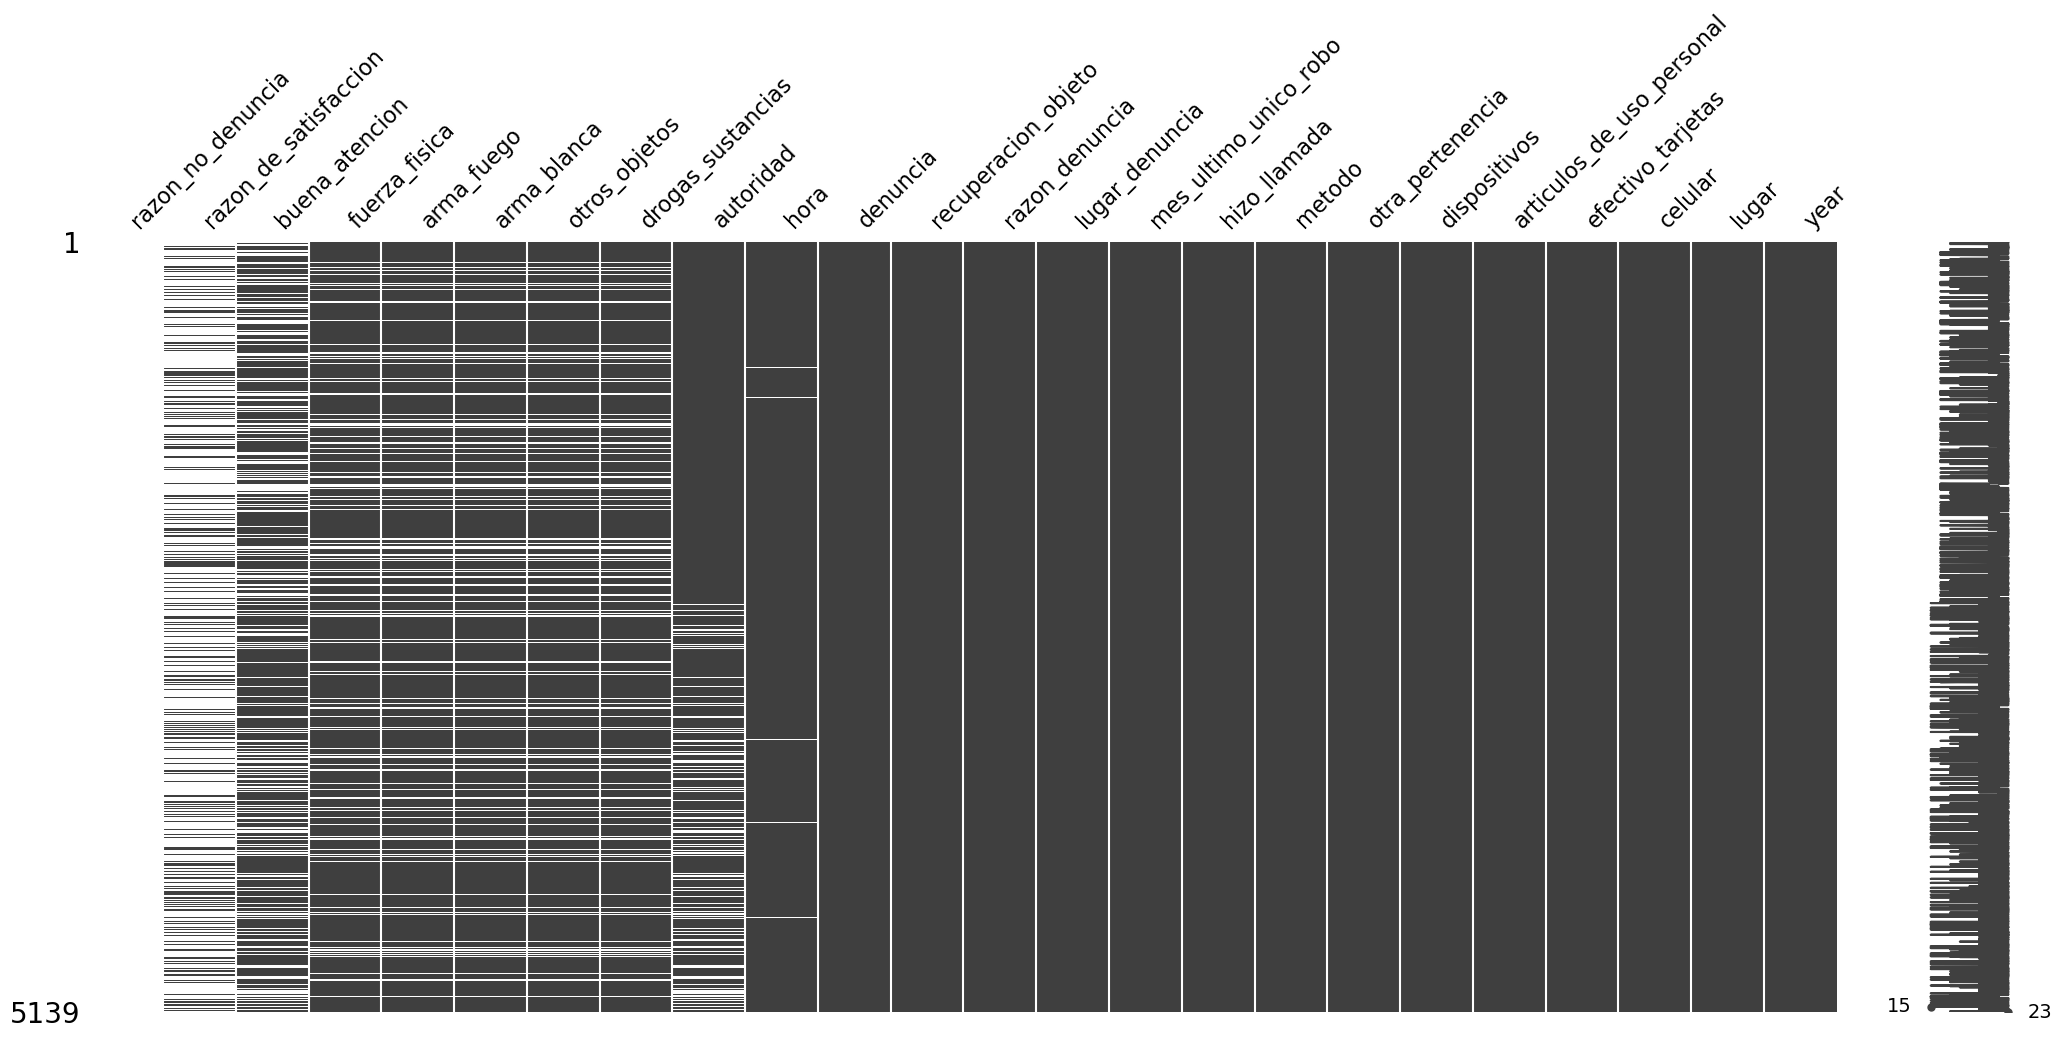

In [283]:
(
    df_si_denuncia
    .ms_tools.sort_variables_by_missingness()
    .sort_values(by='razon_no_denuncia')
    .pipe(missingno.matrix)
)
plt.show()

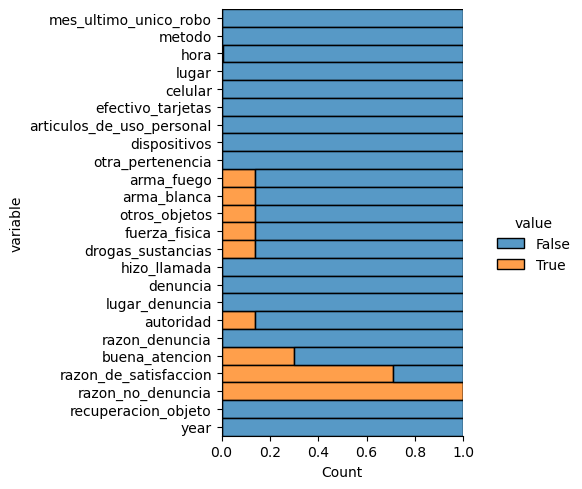

In [284]:
df_si_denuncia.ms_tools.vis_proportion()

### inputación de valores
debido al conocimiento del contexto, voy a rellenar los valores faltantes
de las personas que si denunciaron por "si denuncia" ya que la falta de estos valores
en la columna "razon de la no denuncia" se debe a que estas personas si denunciaron y no 
tenian que responder esta pregunta

In [285]:
df_si_denuncia = df_si_denuncia.fillna(value={'razon_no_denuncia':'si_denuncia'})

# Nuevo DataFrame sin los valores nulos de las personas que no hicieron denuncia

In [286]:
new_df = pd.concat([df_no_denuncia,df_si_denuncia])

In [287]:
#veamos que si tengan los mismos datos
print(df.shape,new_df.shape,sep='\n')

(16188, 24)
(16188, 24)


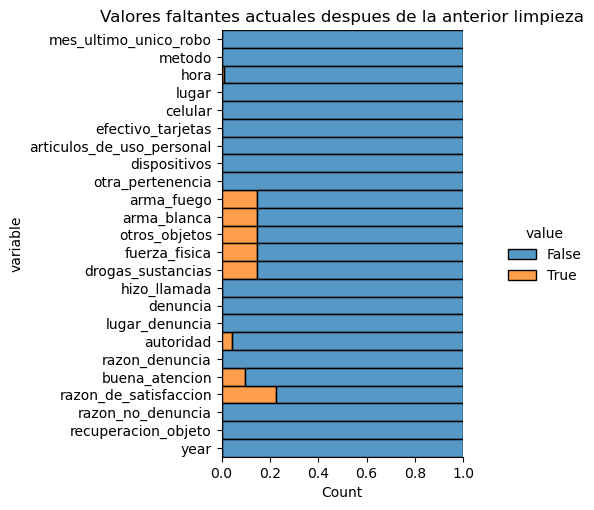

In [288]:
new_df.ms_tools.vis_proportion()
plt.title("Valores faltantes actuales despues de la anterior limpieza")
plt.show()

In [289]:
new_df.ms_tools.table_variable_summary()

,variable,n_missing,n_cases,pct_missing
0,mes_ultimo_unico_robo,0,16188,0.000000
1,metodo,0,16188,0.000000
2,hora,143,16188,0.883370
3,lugar,0,16188,0.000000
4,celular,0,16188,0.000000
5,efectivo_tarjetas,0,16188,0.000000
6,articulos_de_uso_personal,0,16188,0.000000
7,dispositivos,0,16188,0.000000
8,otra_pertenencia,0,16188,0.000000
9,arma_fuego,2362,16188,14.591055


# ¿Qué factores existen para que falten valores en los objetos que utilizaron en el hurto?:

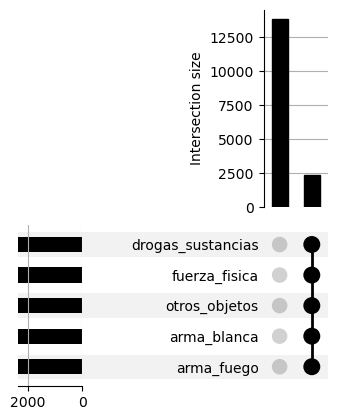

In [290]:
new_df.ms_tools.vis_upsetplot(variables=['arma_fuego', 'arma_blanca', 'otros_objetos',
       'fuerza_fisica', 'drogas_sustancias'])
plt.show()

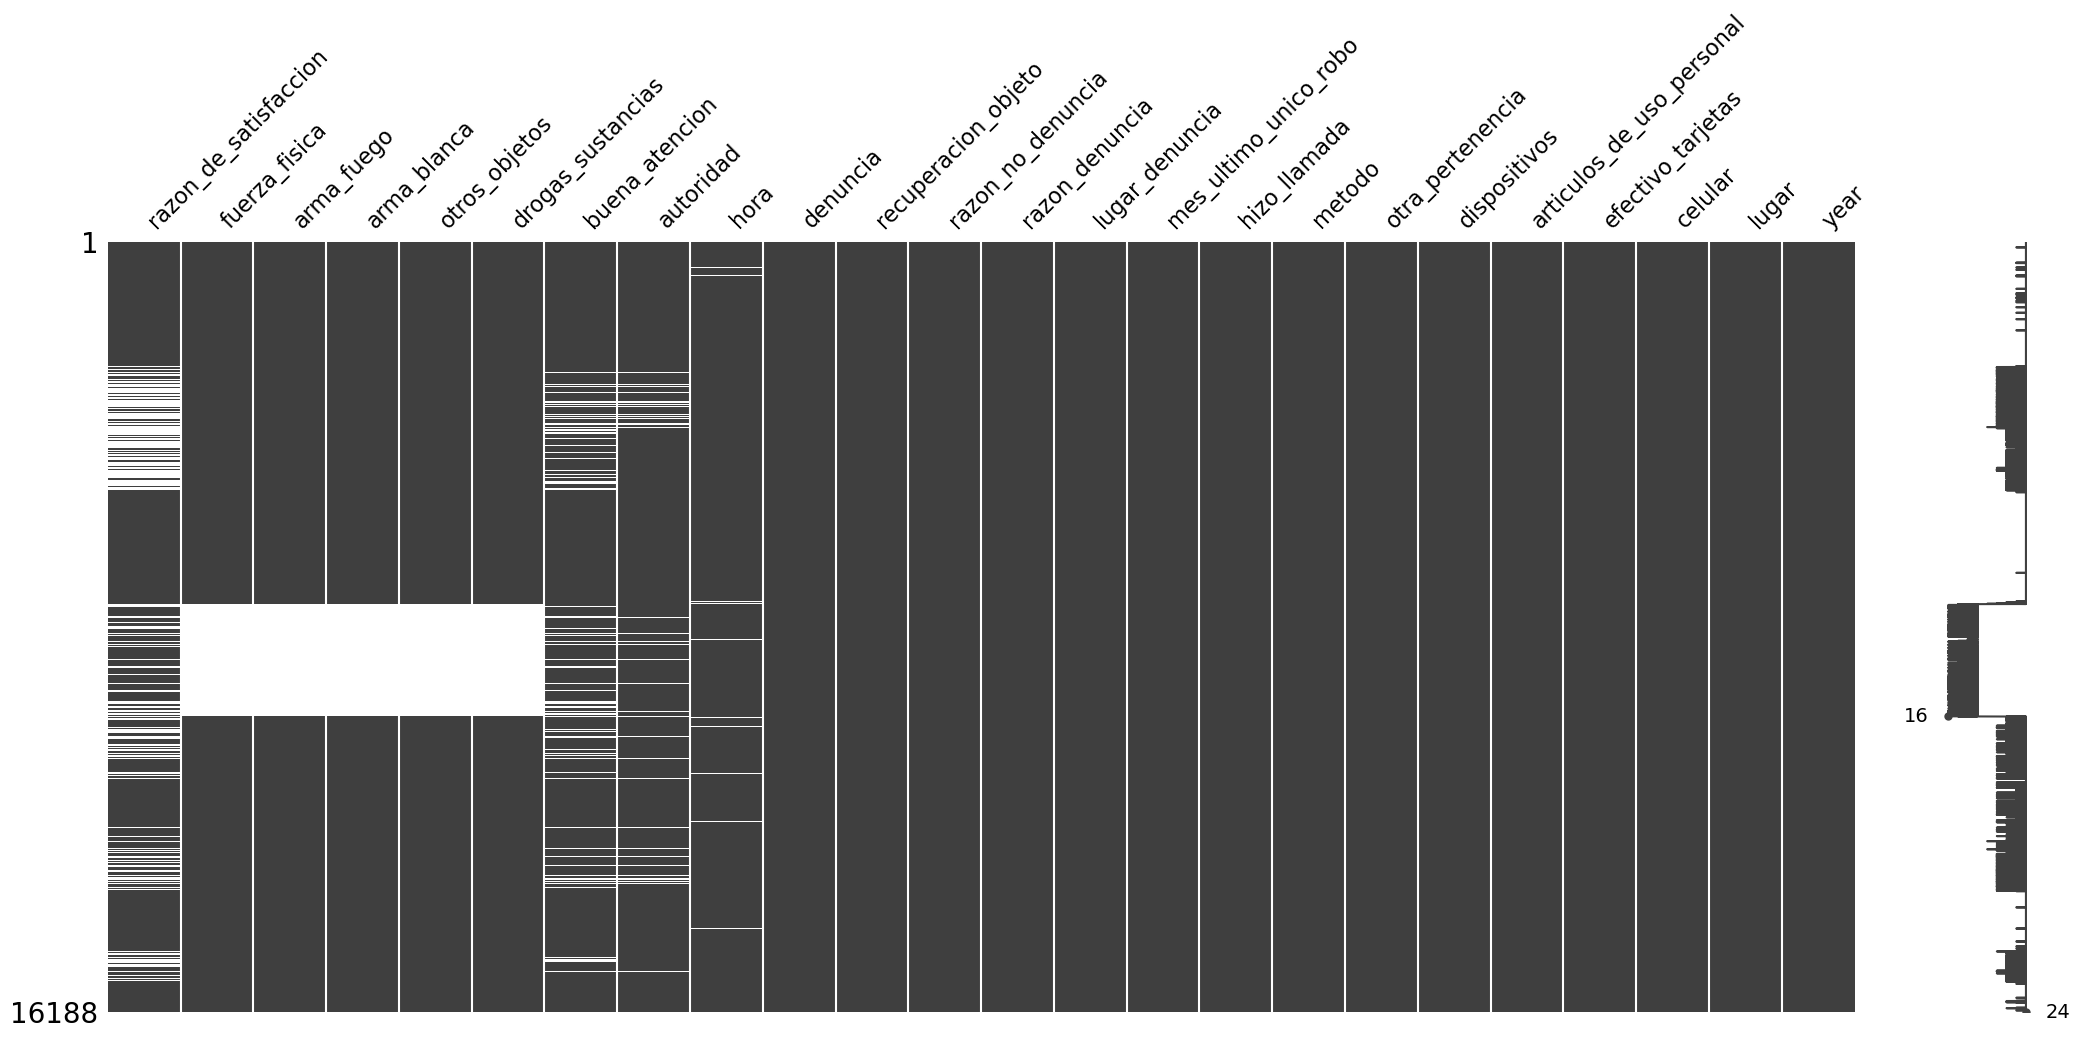

In [291]:
(
    new_df
    .ms_tools
    .sort_variables_by_missingness()
    .sort_values(by='metodo')
    .pipe(missingno.matrix)
)
plt.show()

In [292]:
#Con esto comprobamos que los valores faltantes se deben al tipo de hurto
#cosquilleo 
df_metodo_nulos = new_df[new_df.arma_fuego.isnull()]
df_metodo_nulos.metodo.unique()

array(['cosquilleo'], dtype=object)

### Conclusiones:
Vemos que los valores faltantes de los objetos utilizados para el robo son debido al metodo
de hurto en este caso cosquilleo, por lo cual las victimas no pudierón responder a esta pregunta.
Sin embargo y sabiendo el contexto del metodo de robo, decido imputar el valor "no" en todas las columnas
ya que este metodo no implica ninguna de estas armas u objetos para robar.

In [293]:
new_df = new_df.fillna(value={
    'arma_fuego':'no',
    'arma_blanca':'no',
    'otros_objetos':'no',
    'fuerza_fisica':'no',
    'drogas_sustancias':'no'
    })

# ¿Qué puede seguir influyendo en los valores nulos?

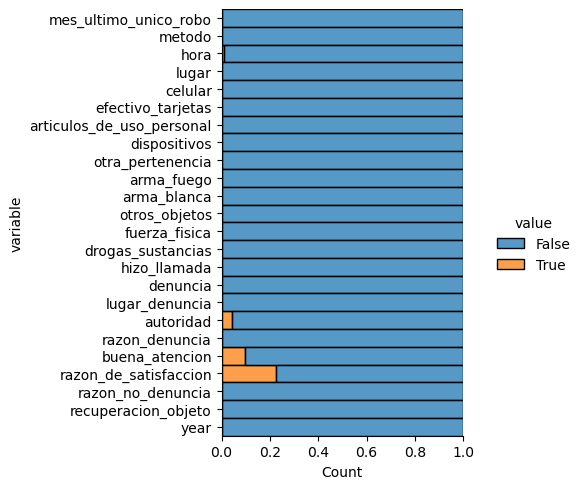

In [294]:
new_df.ms_tools.vis_proportion()

### Hipotesis - lugar donde se denuncia
ya que los valores faltantes tienen que ver con en lugar de denuncia y la satisfacción que recibieron
al denunciar, tal vez sea que las personas no respondieron a esto debido a que lo hicieron a través de
la página web, probemos esta hipotesis:

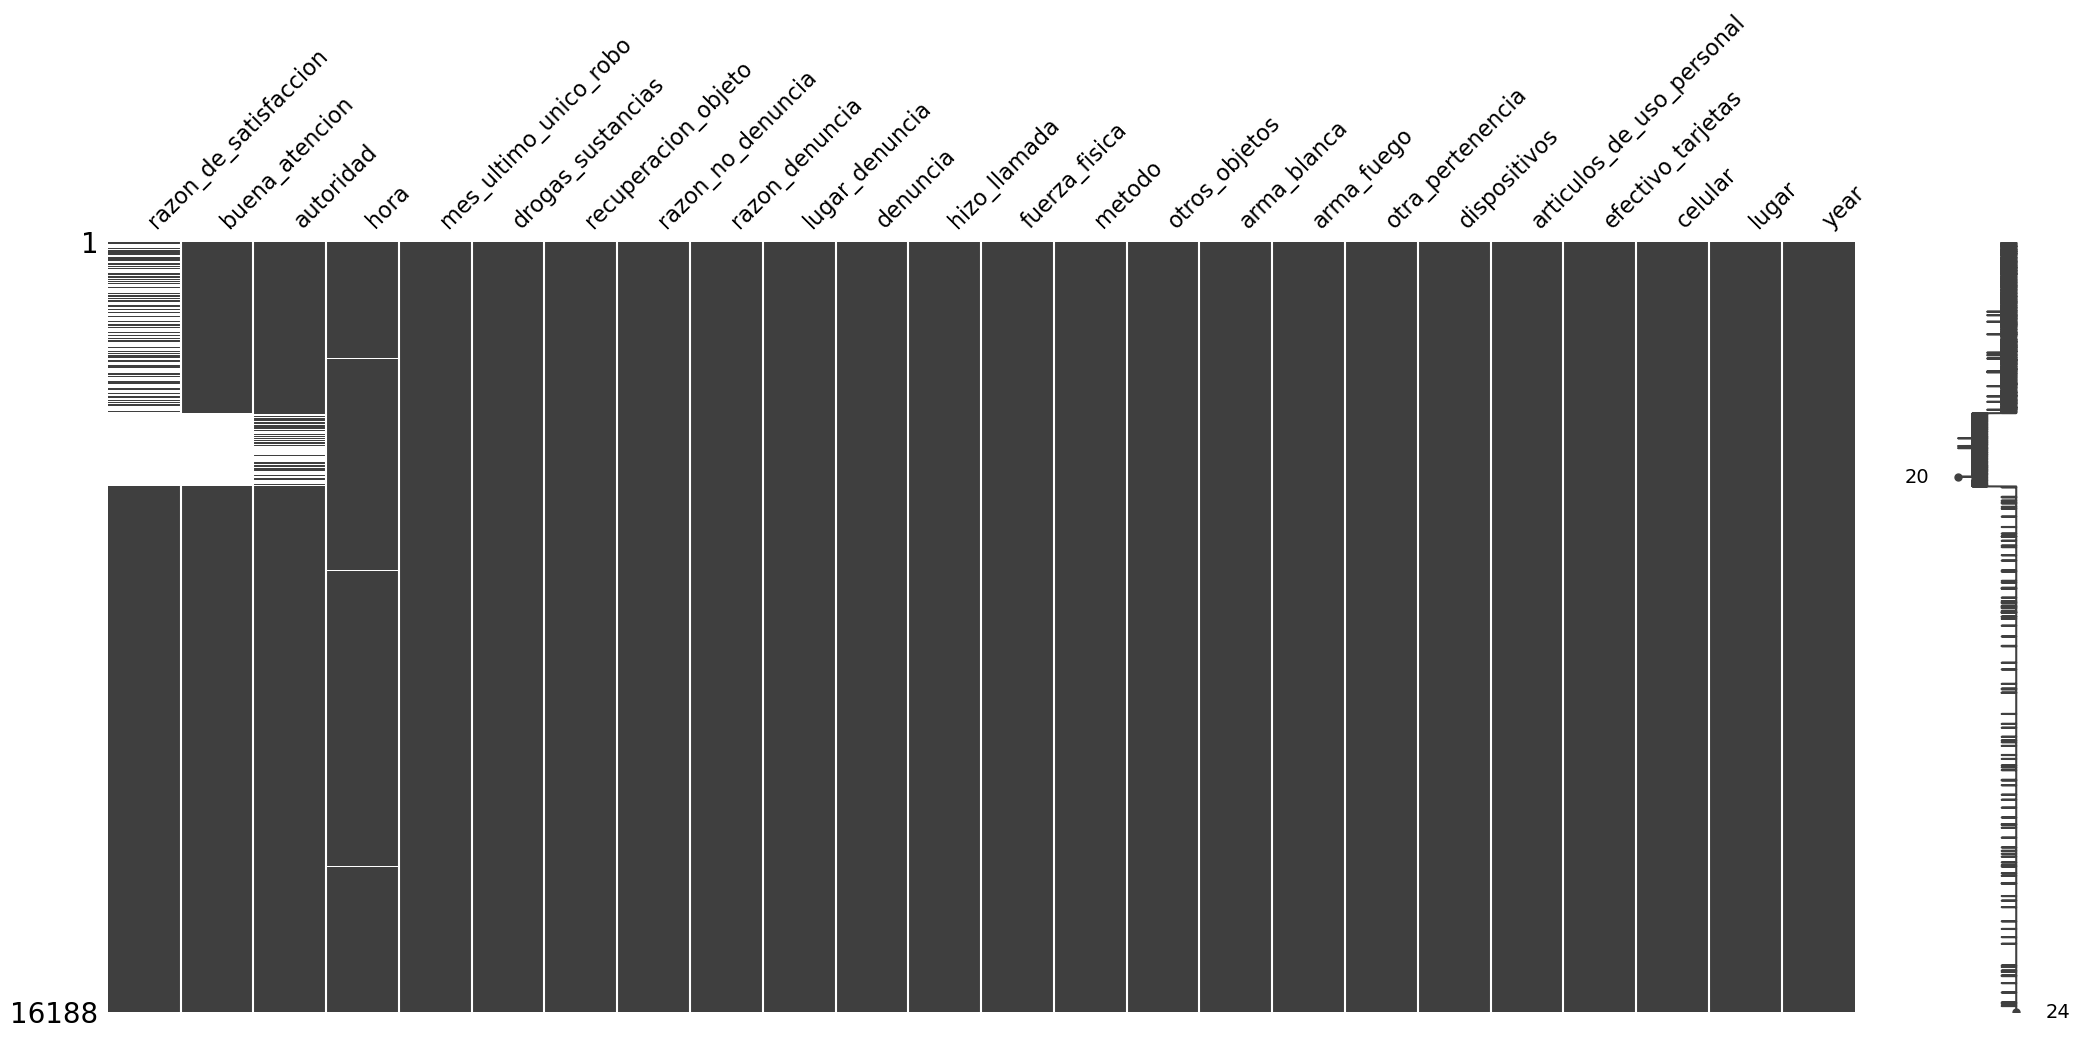

In [295]:
(
    new_df
    .ms_tools
    .sort_variables_by_missingness()
    .sort_values(by='lugar_denuncia')
    .pipe(missingno.matrix)
)
plt.show()

In [296]:
#Comprobando que los valores nulos de si recibieron buena atencion se deba a que las denuncias
#se hicieron por internet
df_denuncias_internet = new_df[new_df.buena_atencion.isnull()]
df_denuncias_internet.lugar_denuncia.unique()

array(['denuncias en línea', 'Reporte de objetos perdidos en línea'],
      dtype=object)

In [297]:
df_denuncias_presenciales = new_df[new_df.buena_atencion.notnull()]

In [298]:
print('df_size:',new_df.shape,'df_1_nulos:',df_1_nulos.shape,'df_2_nonulos:',df_2_nonulos.shape,sep='\n')

df_size:
(16188, 24)
df_1_nulos:
(1539, 24)
df_2_nonulos:
(14649, 24)


### Comprobación de hipotesis:
Comprobamos la hipotesis y los valores faltantes de estos valores se deben a que la denuncia fue presentada
en linea

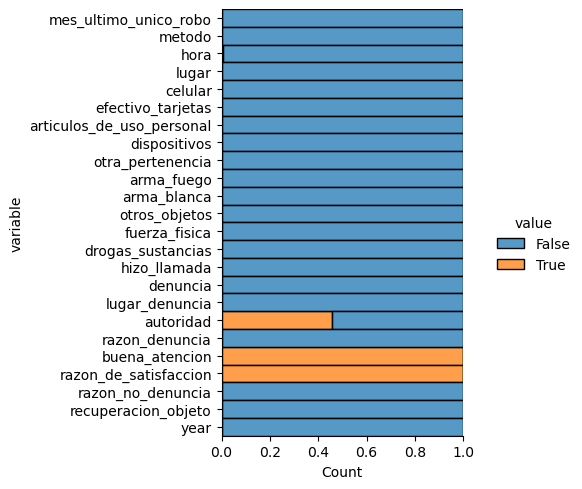

In [299]:
df_denuncias_internet.ms_tools.vis_proportion()

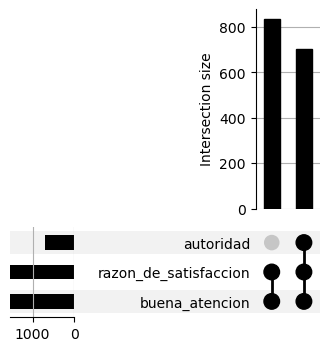

In [300]:
df_denuncias_internet.ms_tools.vis_upsetplot(variables=['autoridad','buena_atencion','razon_de_satisfaccion'])
plt.show()

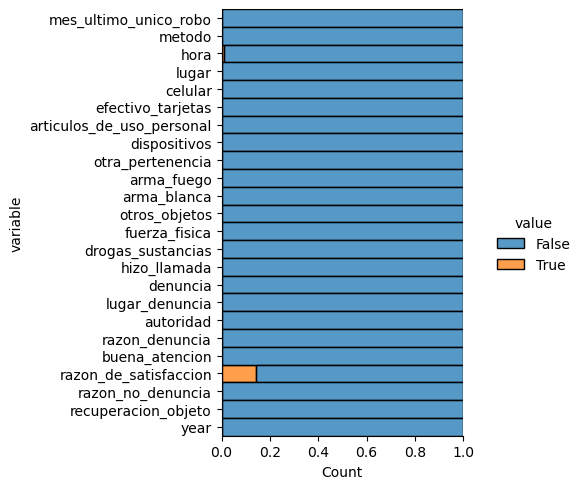

In [301]:
df_denuncias_presenciales.ms_tools.vis_proportion()

#### Inputacion de datos

Vemos que los valores nulos de la razon y denuncia y razon de satisfaccion tienen correlacion con el
lugar donde se hizo la denuncia que es online, por ello rellenare esos valores con "denuncia_online" 

In [302]:
df_denuncias_internet = df_denuncias_internet.fillna(
        value={
            'buena_atencion':'denuncia_online',
            'razon_de_satisfaccion':'denuncia_online'
            }
    )

In [303]:
pre_final_df = pd.concat([df_denuncias_internet,df_denuncias_presenciales])

## Ultimos valores nulos

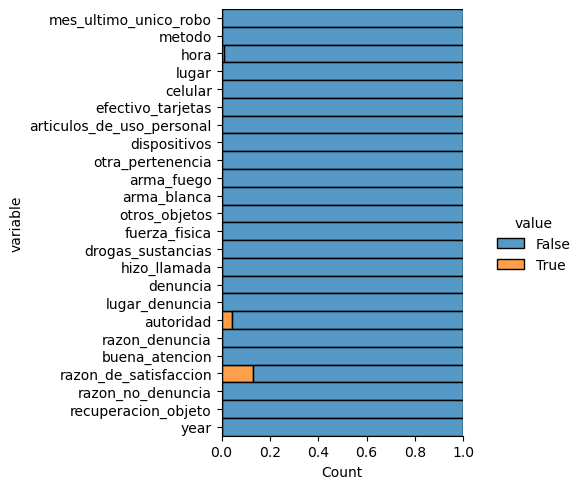

In [304]:
pre_final_df.ms_tools.vis_proportion()

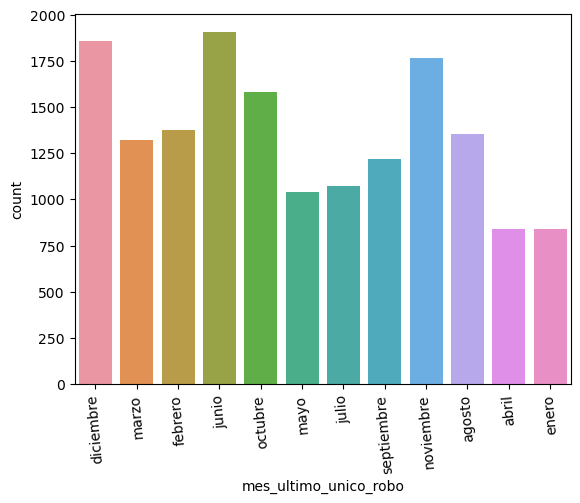

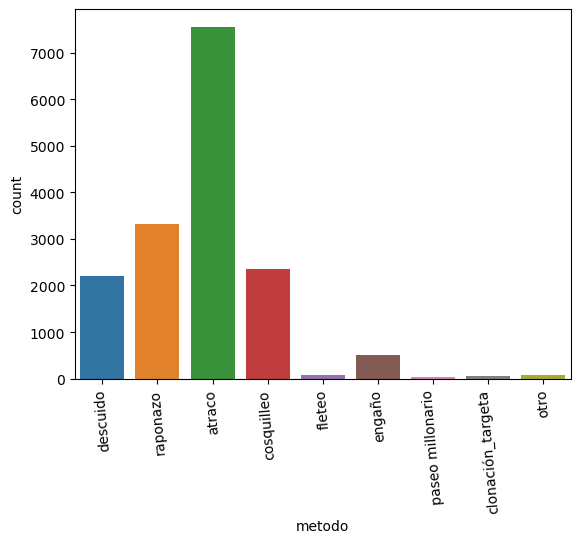

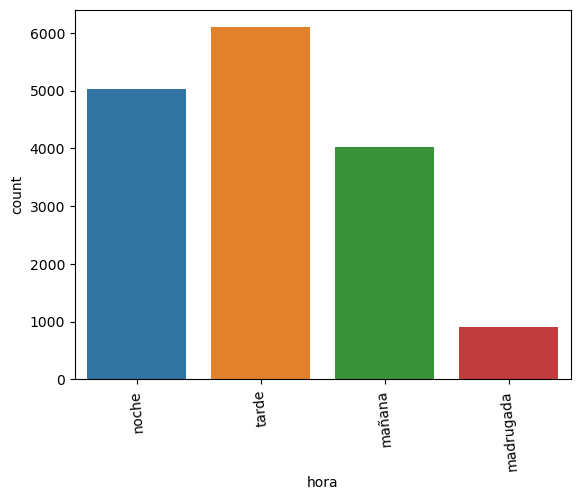

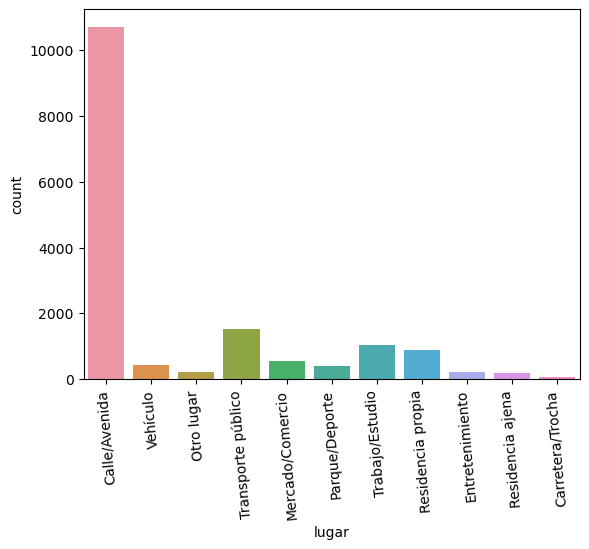

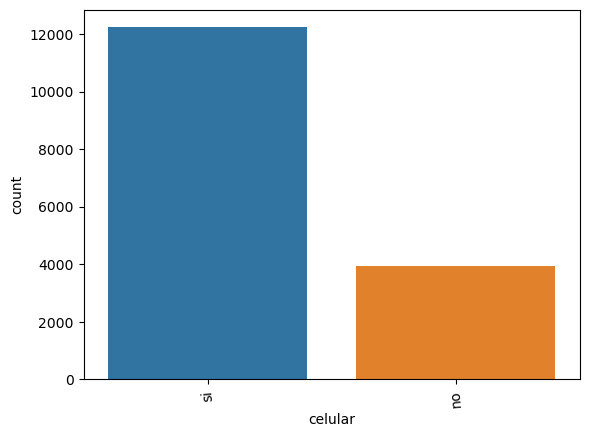

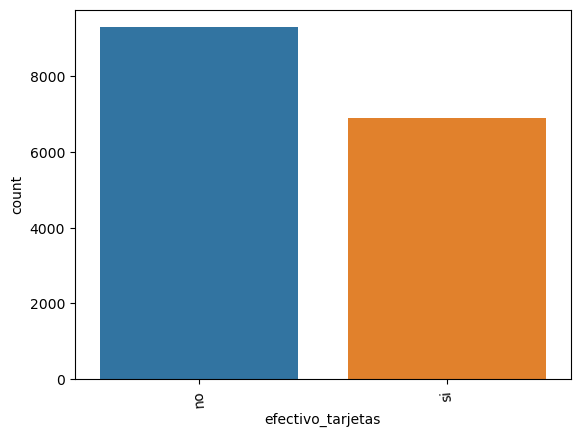

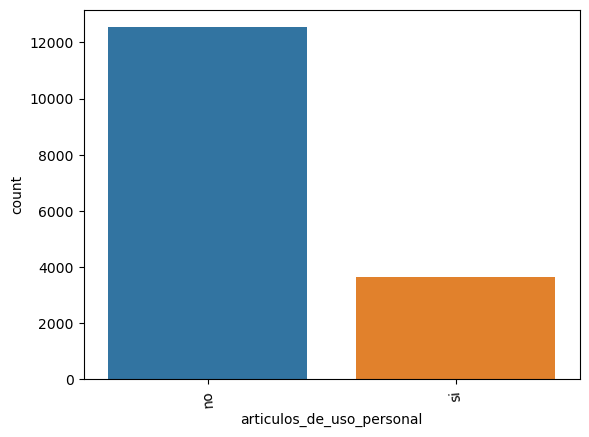

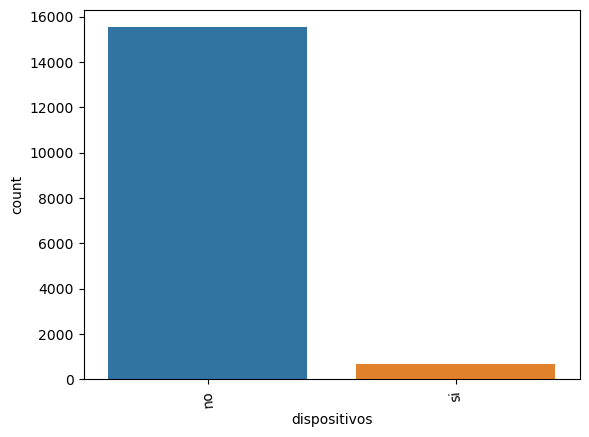

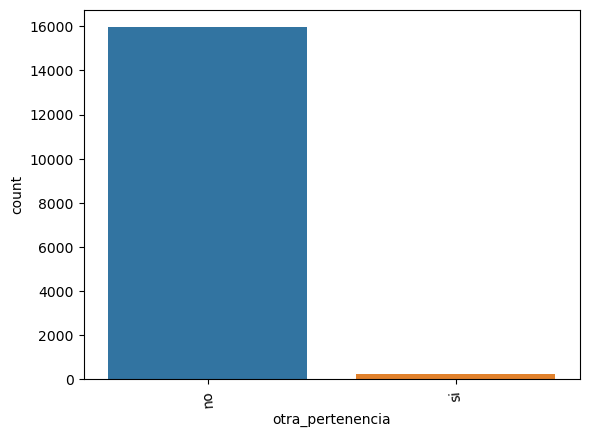

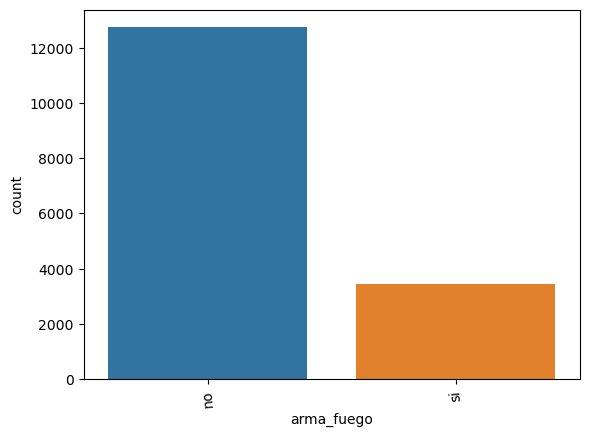

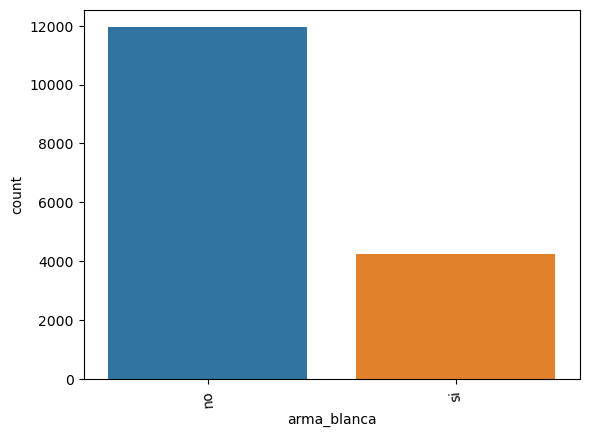

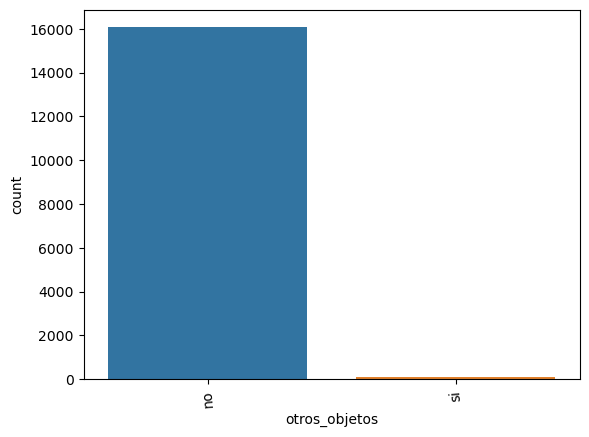

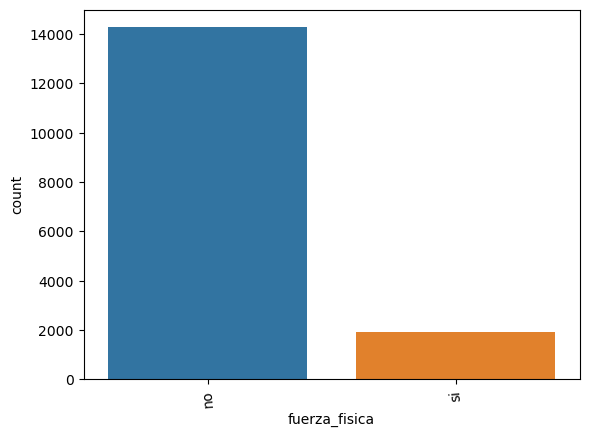

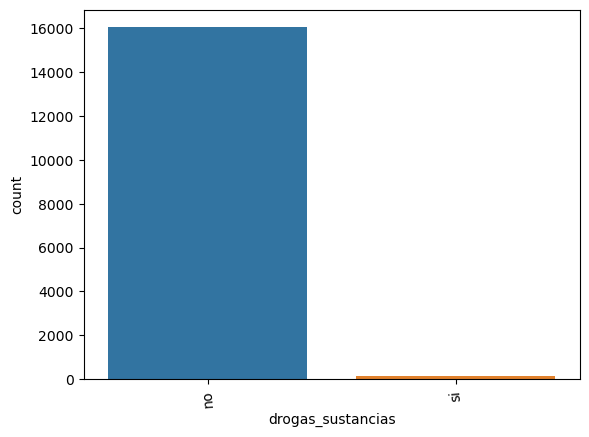

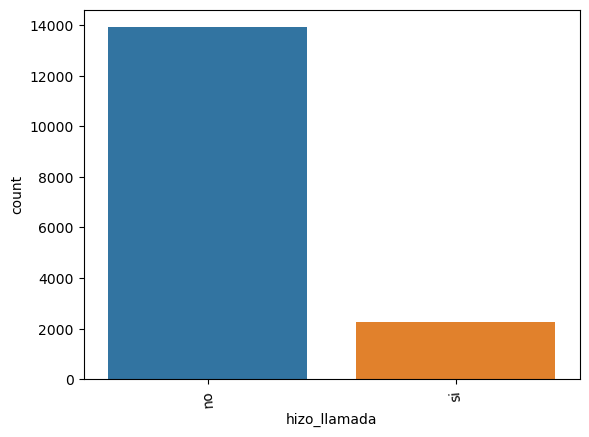

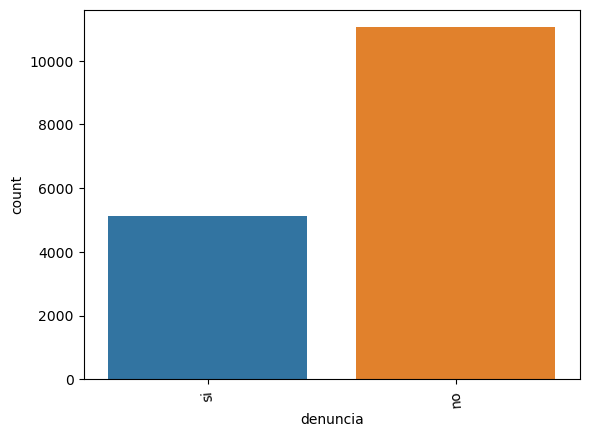

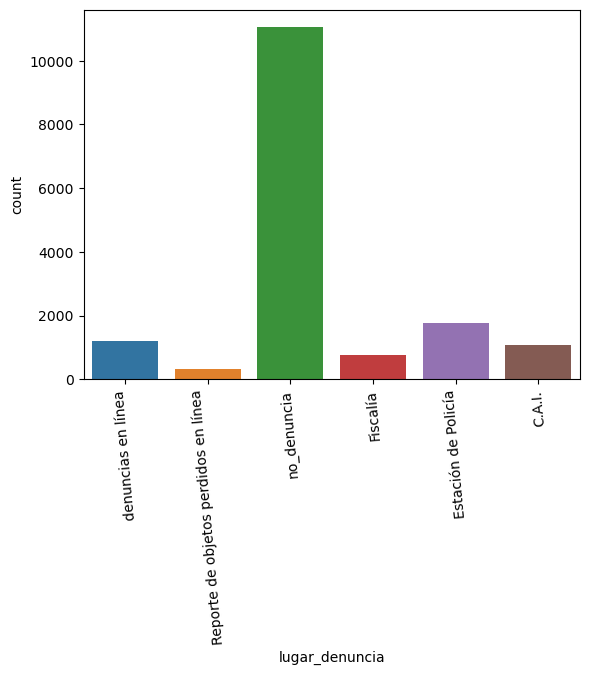

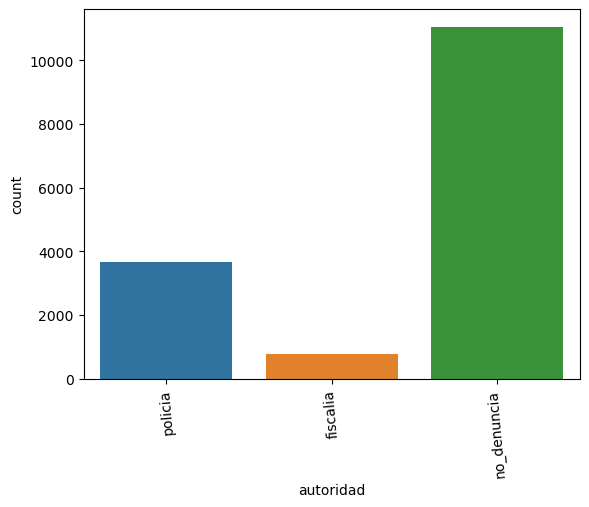

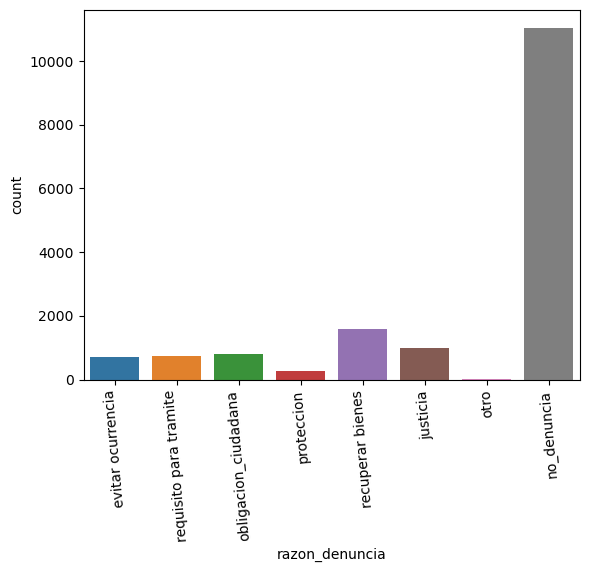

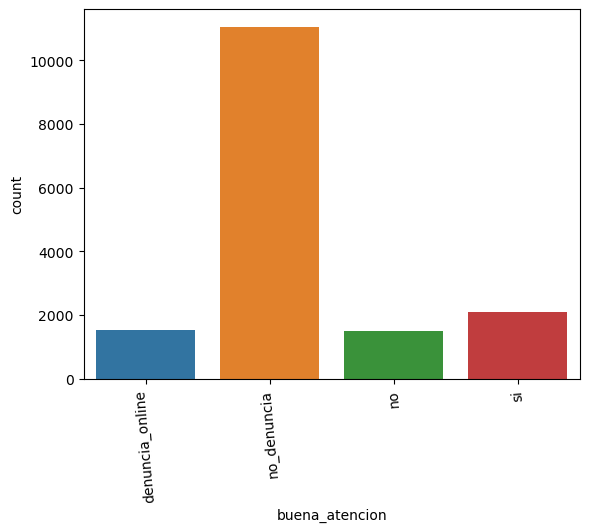

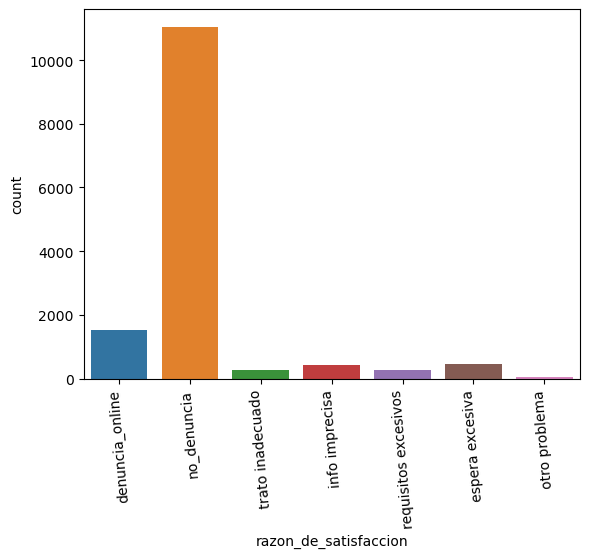

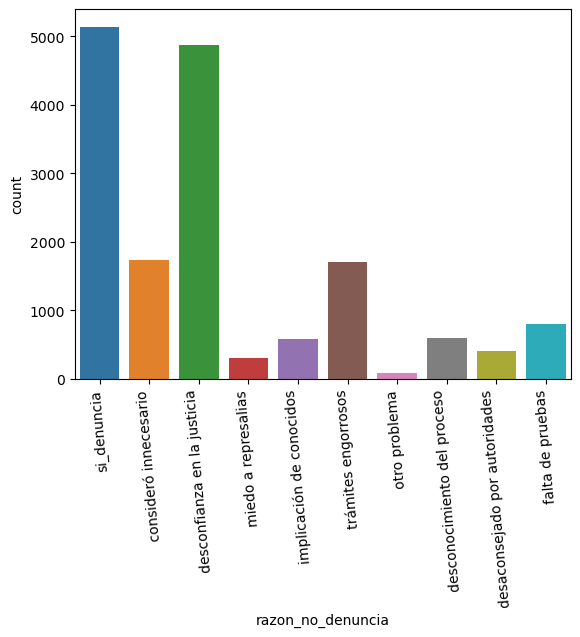

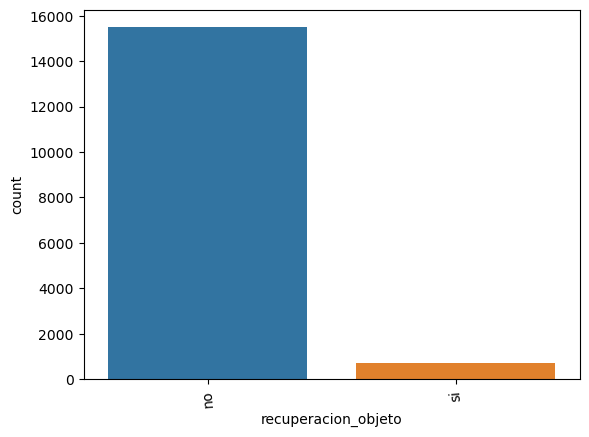

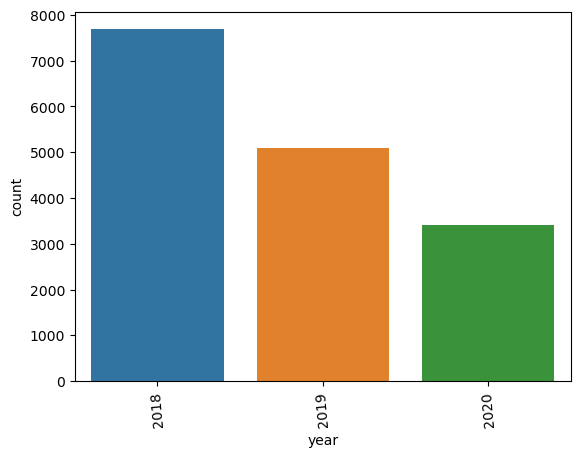

In [305]:
for i in pre_final_df.columns:
    sns.countplot(pre_final_df,x=i)
    plt.xticks(rotation=95)
    plt.show()

# Exportacion dataset

In [306]:
df_processed = pre_final_df

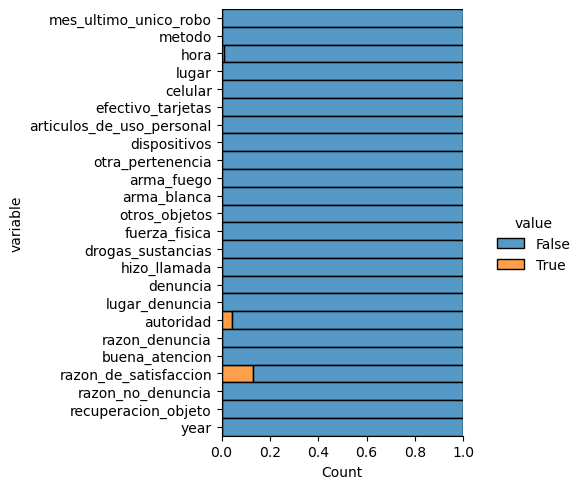

In [307]:
df_processed.ms_tools.vis_proportion()

In [308]:
df_processed.to_csv(
    path_or_buf=data_dir("processed","hurtos_processed.csv"),
    index=False,
    sep=','
)